In [1]:
%matplotlib inline

#Import modules
import os
import pathlib
import sqlite3
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#import csv
import glob as gb

In [25]:
mpl.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_rows = 200

In [2]:
gb.glob('**/*.sql', recursive=True)

['OS/Office_BXL/run/eplusout.sql',
 'OS/Office_Large_Brussels_V10/run/eplusout.sql']

In [3]:
class EPLusSQL():

    def __init__(self, sql_path = None):
        abs_sql_path = os.path.abspath(sql_path)
        self.sql_uri = '{}?mode=ro'.format(pathlib.Path(abs_sql_path).as_uri())
        
    def get_annual_energy_by_fuel_and_enduse(self):
        """
        Queries SQL file and returns the ABUPS' End Uses table

        Parameters
        ----------
        None

        Returns
        -------
        df_end_use: pd.DataFrame
            Annual End Use table
            index = 'EndUse'
            columns = ['FuelType','Units']
        """


        # RowName = '#{end_use}'
        # ColumnName='#{fuel_type}'
        annual_end_use_query = """SELECT RowName, ColumnName, Units, Value
            FROM TabularDataWithStrings
            WHERE ReportName='AnnualBuildingUtilityPerformanceSummary'
            AND ReportForString='Entire Facility'
            AND TableName='End Uses'
        """

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df_end_use = pd.read_sql(annual_end_use_query, con=con)

        # Convert Value to Float
        df_end_use['Value'] = pd.to_numeric(df_end_use['Value'])

        df_end_use = df_end_use.set_index(['RowName',
                                         'ColumnName',
                                         'Units'])['Value'].unstack([1, 2])
        df_end_use.index.name = 'EndUse'
        df_end_use.columns.names = ['FuelType', 'Units']

        end_use_order = ['Heating', 'Cooling',
                         'Interior Lighting', 'Exterior Lighting',
                         'Interior Equipment', 'Exterior Equipment',
                         'Fans', 'Pumps', 'Heat Rejection', 'Humidification',
                         'Heat Recovery', 'Water Systems',
                         'Refrigeration', 'Generators']
        col_order = [
            'Electricity', 'Natural Gas', 'Gasoline', 'Diesel', 'Coal',
            'Fuel Oil No 1', 'Fuel Oil No 2', 'Propane', 'Other Fuel 1',
            'Other Fuel 2', 'District Cooling', 'District Heating',
            'Water']
        df_end_use = df_end_use[col_order].loc[end_use_order]

        # Filter out columns with ALL zeroes
        df_end_use = df_end_use.loc[:,(df_end_use > 0).any(axis=0)]

        return df_end_use


    def get_unmet_hours_table(self):
        """
        Queries 'SystemSummary' and returns all unmet hours

        Parameters
        ----------
        None

        Returns
        -------
        df_unmet: pd.DataFrame
            A DataFrame where


        """

        query = """SELECT RowName, ColumnName, Units, Value FROM TabularDataWithStrings
    WHERE ReportName='SystemSummary'
    AND ReportForString='Entire Facility'
    AND TableName='Time Setpoint Not Met'
    """
        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df_unmet = pd.read_sql(query, con=con)

        # Convert Value to Float
        df_unmet['Value'] = pd.to_numeric(df_unmet['Value'])

        df_unmet = df_unmet.pivot(index='RowName',
                                  columns='ColumnName',
                                  values='Value')

        df_unmet.columns.names = ['Time Setpoint Not Met (hr)']

        # Move 'Facility' as last row (Should always be in the index...)
        if 'Facility' in df_unmet.index:
            df_unmet = df_unmet.loc[[x for x
                                     in df_unmet.index
                                     if x != 'Facility'] + ['Facility']]

        return df_unmet
    
    def get_reporting_vars(self):
        """
        Queries 'ReportingDataDictionary' and returns a DataFrame

        Parameters
        -----------
        None

        Returns
        ---------
        df_vars: pd.DataFrame
            A DataFrame where each row is a reporting variable
        """

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            query = '''
        SELECT KeyValue, Name, TimestepType, ReportingFrequency, Units, Type
            FROM ReportDataDictionary
            '''
            df_vars = pd.read_sql(query, con=con)

        return df_vars
    
    
    def get_hourly_variables(self, variables_list):
        """
        Queries Hourly variables which names are in variables_list
        
        eg: variables_list=['Zone Thermal Comfort CEN 15251 Adaptive Model Temperature']
        """
        
        query = '''
        SELECT EnvironmentPeriodIndex, Month, Day, Hour, Minute,
            ReportingFrequency, KeyValue, Name, Units,
            Value
        FROM ReportVariableWithTime
        '''

        cond = []

        cond.append(
            ("UPPER(Name) IN ({})".format(', '.join(
                              map(repr, [name.upper() for name in variables_list]))))
        )

        cond.append('ReportingFrequency = "Hourly"')

        query += '  WHERE {}'.format('\n    AND '.join(cond))

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df = pd.read_sql(query, con=con)

        df_pivot = pd.pivot_table(df, values='Value',
                                  columns=['ReportingFrequency', 'KeyValue',
                                           'Name', 'Units'],
                                  index=['EnvironmentPeriodIndex',
                                         'Month', 'Day', 'Hour', 'Minute'])

        df_pivot = df_pivot.loc[3] # Get the annual environment period index

        # We know it's hourly, so recreate a clear index
        df_pivot.index = pd.date_range(start='2005-01-01 00:00', periods=8760, freq='H')
        df_pivot = df_pivot['Hourly']

        return df_pivot

## Energy Use by Fuel and End Use

In [4]:
eplus_sql = EPLusSQL(sql_path='OS/Office_BXL/run/eplusout.sql')

In [5]:
df_end_use = eplus_sql.get_annual_energy_by_fuel_and_enduse()
df_end_use.applymap(lambda x: x if x > 0 else '')

FuelType,Electricity,Natural Gas,Water
Units,GJ,GJ,m3
EndUse,,,
Heating,,353.44,
Cooling,402.55,,
Interior Lighting,386.42,,
Exterior Lighting,,,
Interior Equipment,2009.8,,
Exterior Equipment,1900.91,,
Fans,47.81,,
Pumps,160.18,,


## Unmet Hours

In [6]:
df_unmet = eplus_sql.get_unmet_hours_table()
df_unmet

Time Setpoint Not Met (hr),During Cooling,During Heating,During Occupied Cooling,During Occupied Heating
RowName,,,,
BASEMENT_TZ,0.00,0.00,0.00,0.00
GROUNDFLOOR_CORE_TZ,65.50,11.25,5.25,11.25
GROUNDFLOOR_DATACENTER_TZ,2252.25,0.00,0.00,0.00
GROUNDFLOOR_HALL_S_TZ,9.75,106.00,9.25,48.25
GROUNDFLOOR_OFFICES_E_TZ,7.00,108.25,7.00,49.00
GROUNDFLOOR_OFFICES_N_TZ,4.00,132.50,3.50,52.75
GROUNDFLOOR_OFFICES_W_TZ,7.75,118.25,5.25,51.25
GROUNDFLOOR_PLENUM_TZ,0.00,0.00,0.00,0.00
MID_CORE_TZ,42.25,4.50,7.25,4.50


## Look at available reporting variables

In [7]:
df_vars = eplus_sql.get_reporting_vars()
df_vars

,KeyValue,Name,TimestepType,ReportingFrequency,Units,Type
0,Environment,Site Outdoor Air Drybulb Temperature,Zone,Hourly,C,Avg
1,BASEMENT_TZ,Zone Total Internal Total Heating Energy,Zone,Hourly,J,Sum
2,GROUNDFLOOR_CORE_TZ,Zone Total Internal Total Heating Energy,Zone,Hourly,J,Sum
3,GROUNDFLOOR_DATACENTER_TZ,Zone Total Internal Total Heating Energy,Zone,Hourly,J,Sum
4,GROUNDFLOOR_HALL_S_TZ,Zone Total Internal Total Heating Energy,Zone,Hourly,J,Sum
...,...,...,...,...,...,...
242,CHILLER ELECTRIC EIR 3,Chiller Electricity Energy,HVAC System,Hourly,J,Sum
243,BOILER HOT WATER 1,Boiler Heating Energy,HVAC System,Hourly,J,Sum
244,,NaturalGas:Facility,Zone,Zone Timestep,J,Sum
245,,NaturalGas:Facility,Zone,Daily,J,Sum


In [8]:
df_vars['Name'].unique()

array(['Site Outdoor Air Drybulb Temperature',
       'Zone Total Internal Total Heating Energy',
       'Lights Electricity Energy', 'Electricity:Facility',
       'InteriorLights:Electricity', 'Zone Lights Electricity Energy',
       'Electric Equipment Electricity Energy',
       'InteriorEquipment:Electricity',
       'Zone Windows Total Transmitted Solar Radiation Energy',
       'Zone Windows Total Heat Gain Energy',
       'Zone Windows Total Heat Loss Energy',
       'Daylighting Reference Point 1 Illuminance',
       'Zone Mean Radiant Temperature', 'Zone Mean Air Temperature',
       'Zone Operative Temperature', 'Zone Air Temperature',
       'Zone Thermal Comfort CEN 15251 Adaptive Model Temperature',
       'Chiller Electricity Energy', 'Boiler Heating Energy',
       'NaturalGas:Facility'], dtype=object)

## Load comfort variables

In [9]:
comfort_vars = [
#'Zone Air Temperature',
#'Zone Mean Air Temperature',
#'Zone Mean Radiant Temperature',
'Zone Operative Temperature',
'Zone Thermal Comfort CEN 15251 Adaptive Model Temperature'
]

In [11]:
df_vars[df_vars['Name'].isin(comfort_vars)]

,KeyValue,Name,TimestepType,ReportingFrequency,Units,Type
160,BASEMENT_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
162,GROUNDFLOOR_CORE_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
164,GROUNDFLOOR_DATACENTER_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
166,GROUNDFLOOR_HALL_S_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
168,GROUNDFLOOR_OFFICES_E_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
170,GROUNDFLOOR_OFFICES_N_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
172,GROUNDFLOOR_OFFICES_W_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
174,GROUNDFLOOR_PLENUM_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
176,MID_CORE_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg
178,MID_DATACENTER_TZ,Zone Operative Temperature,Zone,Hourly,C,Avg


In [12]:
df = eplus_sql.get_hourly_variables(variables_list=comfort_vars)

Name
Zone Operative Temperature                                   AxesSubplot(0.125,0.125;0.775x0.755)
Zone Thermal Comfort CEN 15251 Adaptive Model Temperature    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

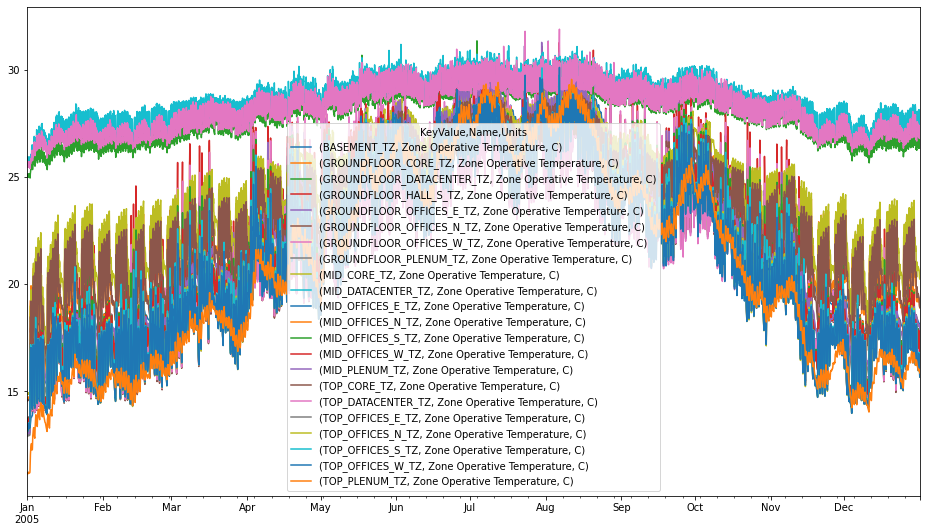

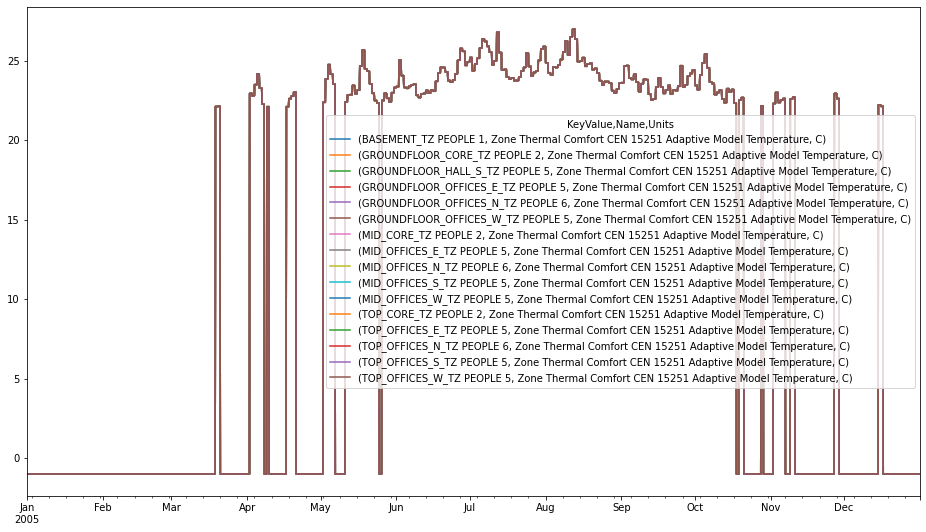

In [22]:
df.groupby(level=1, axis=1).plot(figsize=(16, 9))

In [21]:
df.loc[:, pd.IndexSlice[:, 'Zone Thermal Comfort CEN 15251 Adaptive Model Temperature']]

KeyValue,BASEMENT_TZ PEOPLE 1,GROUNDFLOOR_CORE_TZ PEOPLE 2,GROUNDFLOOR_HALL_S_TZ PEOPLE 5,GROUNDFLOOR_OFFICES_E_TZ PEOPLE 5,GROUNDFLOOR_OFFICES_N_TZ PEOPLE 6,GROUNDFLOOR_OFFICES_W_TZ PEOPLE 5,MID_CORE_TZ PEOPLE 2,MID_OFFICES_E_TZ PEOPLE 5,MID_OFFICES_N_TZ PEOPLE 6,MID_OFFICES_S_TZ PEOPLE 5,MID_OFFICES_W_TZ PEOPLE 5,TOP_CORE_TZ PEOPLE 2,TOP_OFFICES_E_TZ PEOPLE 5,TOP_OFFICES_N_TZ PEOPLE 6,TOP_OFFICES_S_TZ PEOPLE 5,TOP_OFFICES_W_TZ PEOPLE 5
Name,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature,Zone Thermal Comfort CEN 15251 Adaptive Model Temperature
Units,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C
2005-01-01 00:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2005-01-01 01:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2005-01-01 02:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2005-01-01 03:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2005-01-01 04:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-31 19:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2005-12-31 20:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


<AxesSubplot:>

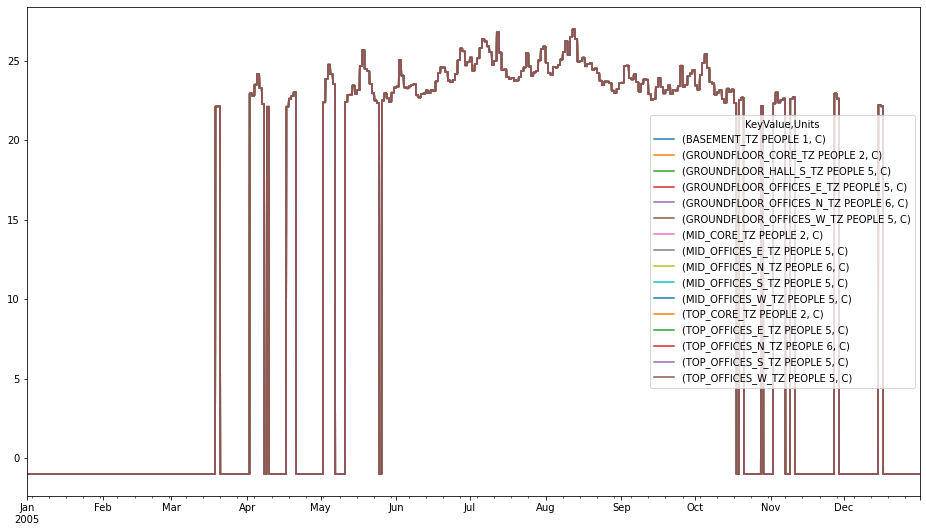

In [29]:
df.swaplevel(0, 1, axis=1)['Zone Thermal Comfort CEN 15251 Adaptive Model Temperature'].plot()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

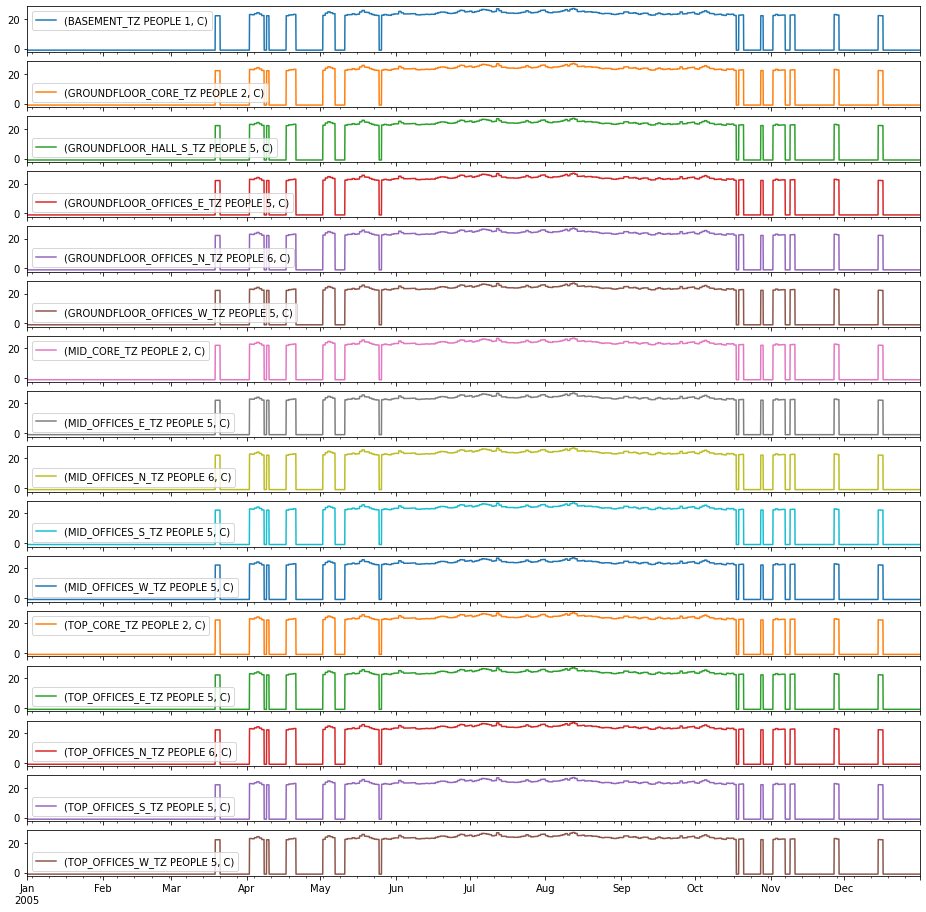

In [28]:
df.swaplevel(0, 1, axis=1)['Zone Thermal Comfort CEN 15251 Adaptive Model Temperature'].plot(subplots=True, figsize=(16, 16))